Show that emll can detect allostery in TopB-reg2-stronger


# Set up 

In [1]:
topology='B'
omission='reg2-stronger'

In [2]:
SEED = 1
import random

import tellurium as te
import pandas as pd
import numpy as np
np.random.seed(SEED)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pytensor.tensor as at
import pytensor
floatX = pytensor.config.floatX
import pymc as pm

import cobra
import os

from scipy import stats
import scipy as sp
import math

import gzip
import cloudpickle

In [3]:
import emll
from emll.pytensor_utils import LeastSquaresSolve

In [4]:
os.chdir('../../..')
from src import antemll, util_pytensor
os.chdir('notebooks/topologyB/all_data')

# Perturbing enzymes

In [5]:
Teusink_ant ='../../../models/Antimony/topologyB-reg2-stronger.ant' 
r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.simulate(0,100)
r.steadyState()

6.549580163038828e-16

In [6]:
pt_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.5, 3, 5, 7, 10]
pt_labels = ['0.1x', '0.2x', '0.3x', '0.4x','0.5x', '1.5x', '3x', '5x', '7x', '10x']

In [7]:
data_file01 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_0.1.csv'
data_file02 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_0.2.csv'
data_file03 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_0.3.csv'
data_file04 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_0.4.csv'
data_file05 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_0.5.csv'

data_file15 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_1.5.csv'
data_file3 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_3.csv'
data_file5 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_5.csv'
data_file7 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_7.csv'
data_file100 = '../../../data/generated_data/topologyB-reg2-stronger/topologyB-reg2-stronger_10.csv'


In [8]:
BMCA_obj01 = antemll.antemll(Teusink_ant, data_file01, '../../../models/sbml/topologyB_cobra.xml')
BMCA_obj02 = antemll.antemll(Teusink_ant, data_file02, '../../../models/sbml/topologyB_cobra.xml')
BMCA_obj03 = antemll.antemll(Teusink_ant, data_file03, '../../../models/sbml/topologyB_cobra.xml')
BMCA_obj04 = antemll.antemll(Teusink_ant, data_file04, '../../../models/sbml/topologyB_cobra.xml')
BMCA_obj05 = antemll.antemll(Teusink_ant, data_file05, '../../../models/sbml/topologyB_cobra.xml')

BMCA_obj15 = antemll.antemll(Teusink_ant, data_file15, '../../../models/sbml/topologyB_cobra.xml')
BMCA_obj3 = antemll.antemll(Teusink_ant, data_file3, '../../../models/sbml/topologyB_cobra.xml')
BMCA_obj5 = antemll.antemll(Teusink_ant, data_file5, '../../../models/sbml/topologyB_cobra.xml')
BMCA_obj7 = antemll.antemll(Teusink_ant, data_file7, '../../../models/sbml/topologyB_cobra.xml')
BMCA_obj100 = antemll.antemll(Teusink_ant, data_file100, '../../../models/sbml/topologyB_cobra.xml')


../../../models/Antimony/topologyB_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-24


No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


No objective coefficients in model. Unclear what should be optimized


../../../models/Antimony/topologyB_cobra.ant


# Running BMCA

In [9]:
def run_prior_predictive(BMCA_obj):

    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sigma=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sigma=1, alpha=5))

        trace_prior = pm.sample_prior_predictive(random_seed=SEED)

    return trace_prior

In [10]:
def run_ADVI(BMCA_obj):
    np.random.seed(SEED)
    random.seed(SEED)
    
    ll = emll.LinLogLeastNorm(BMCA_obj.N, BMCA_obj.Ex.to_numpy(), BMCA_obj.Ey.to_numpy(), BMCA_obj.v_star, driver='gelsy')
    
    with pm.Model() as pymc_model:
        # Initialize elasticities
        # Ex and Ey have to be shape (rxns, mets)
        Ex_t = pm.Deterministic('Ex', emll.util.initialize_elasticity(BMCA_obj.Ex.to_numpy().T, 'Ex', b=0.05, sigma=1, alpha=5))
        Ey_t = pm.Deterministic('Ey', emll.util.initialize_elasticity(BMCA_obj.Ey.to_numpy().T, 'Ey', b=0.05, sigma=1, alpha=5))

        # Error priors. 
        v_err = pm.HalfNormal('v_error', sigma=0.05, initval=.1)
        x_err = pm.HalfNormal('x_error', sigma=0.05, initval=.1)

        # Calculate steady-state concentrations and fluxes from elasticities
        chi_ss, v_hat_ss = ll.steady_state_pytensor(Ex_t, Ey_t, BMCA_obj.en.values, BMCA_obj.yn.values)
        
        # Error distributions for observed steady-state concentrations and fluxes
        chi_obs = pm.Normal('chi_obs', mu=chi_ss, sigma=x_err, observed=BMCA_obj.xn.values)
        v_hat_obs = pm.Normal('v_hat_obs', mu=v_hat_ss.squeeze(),
                            sigma=v_err, observed=BMCA_obj.vn.squeeze())
        
        N_ITERATIONS = 150000

    with pymc_model:
        advi = pm.ADVI(random_seed=SEED)
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n= N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-2), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    with pymc_model:
        trace = approx.sample(draws=1000, random_seed=SEED)
        ppc_vi = pm.sample_posterior_predictive(trace, random_seed=SEED)
    
    return trace, ppc_vi

Finished [100%]: Average Loss = 314.62


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -6.1036


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -301.53


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -553.9
Sampling: [chi_obs, v_hat_obs]


['chain', 'draw']


Finished [100%]: Average Loss = -793.43


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -1,292.2


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -459.93


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = -99.463


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = 3.1894e+06


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


Finished [100%]: Average Loss = 427.91


['chain', 'draw']


Sampling: [chi_obs, v_hat_obs]


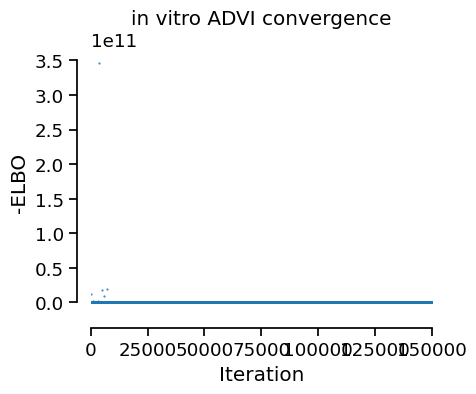

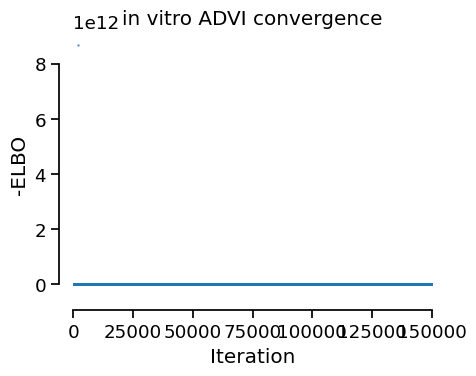

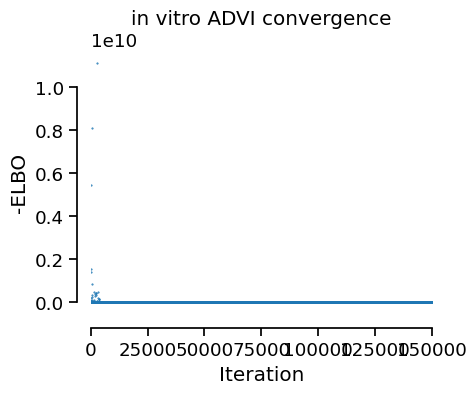

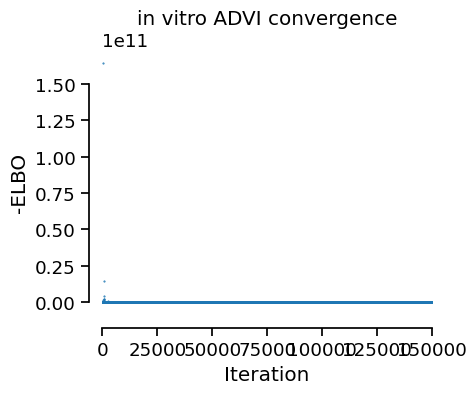

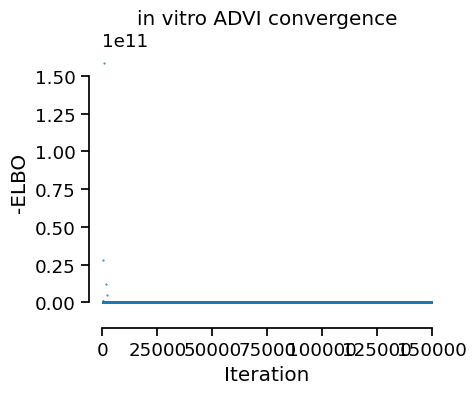

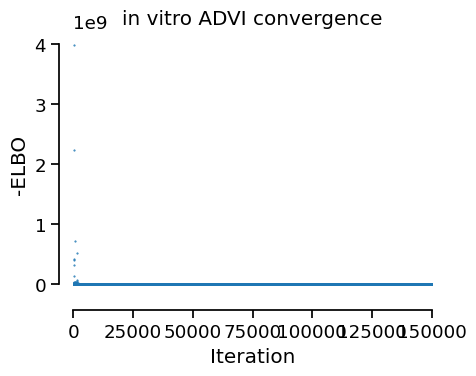

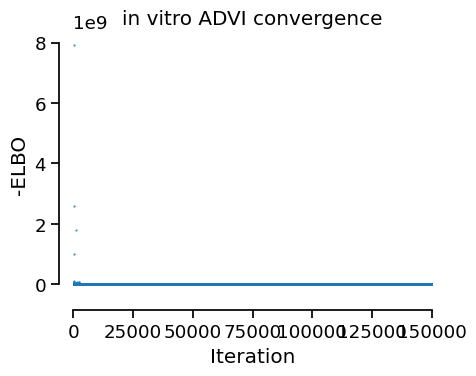

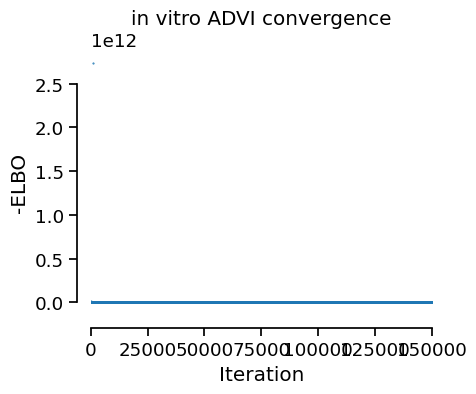

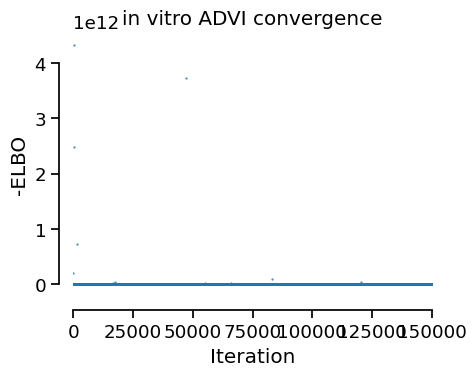

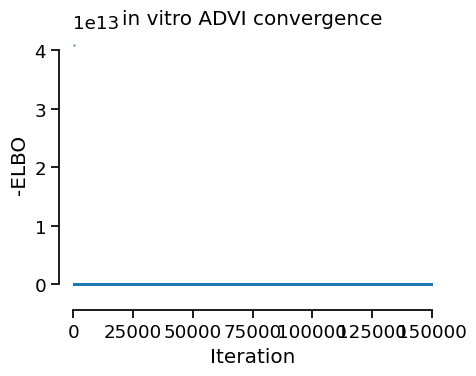

In [11]:
trace01, ppc01 = run_ADVI(BMCA_obj01)
trace02, ppc02 = run_ADVI(BMCA_obj02)
trace03, ppc03 = run_ADVI(BMCA_obj03)
trace04, ppc04 = run_ADVI(BMCA_obj04)
trace05, ppc05 = run_ADVI(BMCA_obj05)

trace15, ppc15 = run_ADVI(BMCA_obj15)
trace3, ppc3 = run_ADVI(BMCA_obj3)
trace5, ppc5 = run_ADVI(BMCA_obj5)
trace7, ppc7 = run_ADVI(BMCA_obj7)
trace100, ppc100 = run_ADVI(BMCA_obj100)

### saving trace data

In [12]:
with gzip.open(f"../../../data/results/tracePickles/aardvark-{topology}-{omission}.pgz", "wb") as f:
            cloudpickle.dump(
                {
                "trace01":trace01,
                "trace02":trace02,
                "trace03":trace03,
                "trace04":trace04,
                "trace05":trace05,
                "trace15":trace15,
                "trace3":trace3,
                "trace5":trace5,
                "trace7":trace7,
                "trace100":trace100, 
                
                "ppc01":ppc01,
                "ppc02":ppc02,
                "ppc03":ppc03,
                "ppc04":ppc04,
                "ppc05":ppc05,
                "ppc15":ppc15,
                "ppc3":ppc3,
                "ppc5":ppc5,
                "ppc7":ppc7,
                "ppc100":ppc100
                },
                f,
            )

# Analysis

In [13]:
with gzip.open(f'../../../data/results/tracePickles/aardvark-{topology}-{omission}.pgz', "rb") as f:
    traces = cloudpickle.load(f, encoding='bytes')

In [14]:
trace01=traces['trace01']
trace02=traces['trace02']
trace03=traces['trace03']
trace04=traces['trace04']
trace05=traces['trace05']

trace15=traces['trace15']
trace3=traces['trace3']
trace5=traces['trace5']
trace7=traces['trace7']
trace100=traces['trace100']

### Elasticity check

In [15]:
Ex01_advi = util_pytensor.get_az_summary(trace01)
Ex02_advi = util_pytensor.get_az_summary(trace02)
Ex03_advi = util_pytensor.get_az_summary(trace03)
Ex04_advi = util_pytensor.get_az_summary(trace04)
Ex05_advi = util_pytensor.get_az_summary(trace05)

Ex15_advi = util_pytensor.get_az_summary(trace15)
Ex3_advi = util_pytensor.get_az_summary(trace3)
Ex5_advi = util_pytensor.get_az_summary(trace5)
Ex7_advi = util_pytensor.get_az_summary(trace7)
Ex100_advi = util_pytensor.get_az_summary(trace100)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: 

In [16]:
elasticity_values = np.column_stack([r.getScaledElasticityMatrix().flatten(),
                                -Ex01_advi, -Ex02_advi, -Ex03_advi, 
                                -Ex04_advi, -Ex05_advi,  
                                -Ex15_advi, -Ex3_advi, -Ex5_advi, 
                                -Ex7_advi, -Ex100_advi])

elasticities_df = pd.DataFrame(elasticity_values, columns=['gt']+pt_labels, 
                               index=[i + '_' + ii for i in r.getReactionIds() for ii in r.getFloatingSpeciesIds()])
# elasticities_df.to_csv('topologyB-noReg_allData_elasticities.csv')

In [18]:
elasticities_df.loc['v5_H']

gt     -2.605603
0.1x   -0.001000
0.2x   -0.020000
0.3x   -0.037000
0.4x   -0.012000
0.5x   -0.033000
1.5x   -0.038000
3x     -0.043000
5x     -0.044000
7x      0.017000
10x    -0.375000
Name: v5_H, dtype: float64

In [19]:
elasticities_df.loc['v14_O']

gt     -3.278032
0.1x   -0.488000
0.2x    0.269000
0.3x   -0.014000
0.4x    0.322000
0.5x   -0.018000
1.5x   -0.008000
3x      0.322000
5x      0.001000
7x     -0.873000
10x    -0.039000
Name: v14_O, dtype: float64

In [17]:
e_slopes = [round(util_pytensor.calculate_slope(elasticities_df['gt'], elasticities_df[i])[0],3) for i in pt_labels]
e_intercepts = [round(util_pytensor.calculate_slope(elasticities_df['gt'], elasticities_df[i])[1],3) for i in pt_labels]
e_r2s = [round(util_pytensor.calculate_slope(elasticities_df['gt'], elasticities_df[i])[2],3) for i in pt_labels]

### elasticity graphs

(-5.0, 5.0)

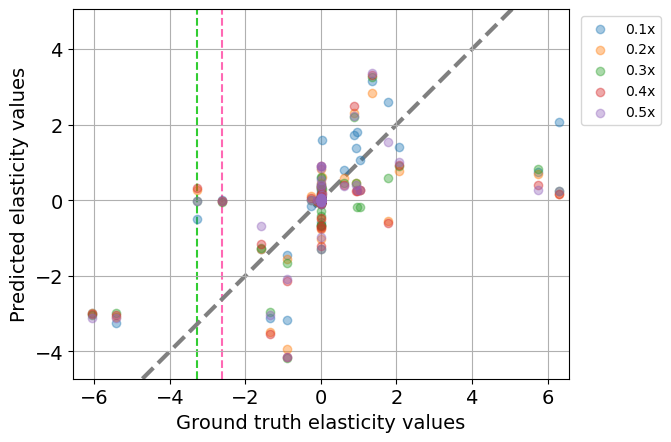

In [21]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)

plt.axvline(x=elasticities_df.loc['v5_H']['gt'], c='hotpink', linestyle='dashed', zorder=0)
plt.axvline(x=elasticities_df.loc['v14_O']['gt'], c='limegreen', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth elasticity values', size=14)
plt.ylabel('Predicted elasticity values', size=14)

plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.xticks(size=14)
plt.yticks(size=14)

plt.xlim(-5,5)

(-5.0, 5.0)

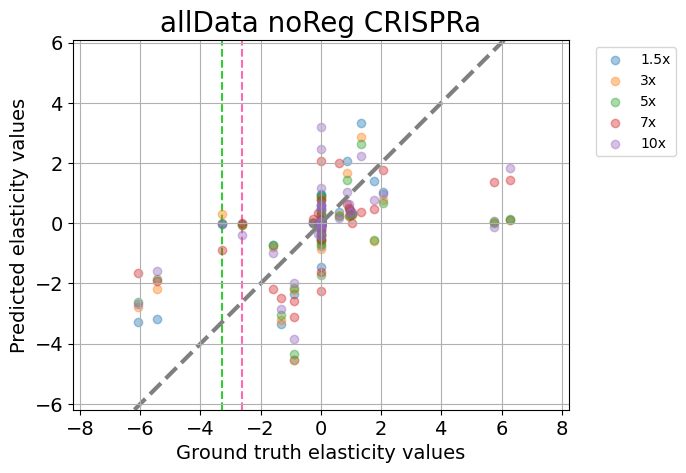

In [23]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x')
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x')
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x')
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x')
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x')

plt.axvline(x=elasticities_df.loc['v5_H']['gt'], c='hotpink', linestyle='dashed', zorder=0)
plt.axvline(x=elasticities_df.loc['v14_O']['gt'], c='limegreen', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1,linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth elasticity values', size=14)
plt.ylabel('Predicted elasticity values', size=14)
plt.title('allData noReg CRISPRa', size=20)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.xticks(size=14)
plt.yticks(size=14)

plt.xlim(-5,5)

(-5.0, 5.0)

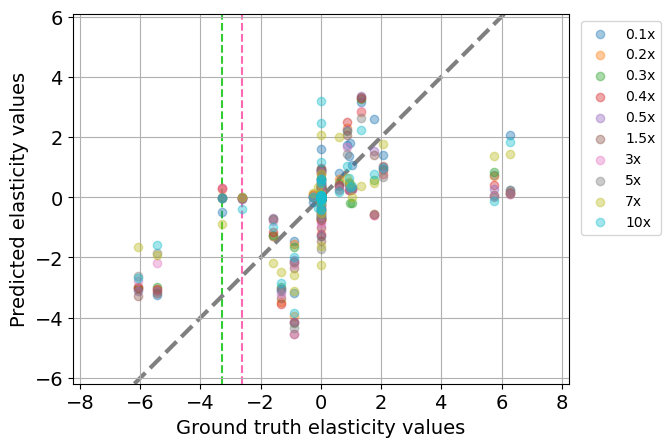

In [25]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(elasticities_df['gt'], elasticities_df['0.1x'], alpha=0.4, label='0.1x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.2x'], alpha=0.4, label='0.2x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.3x'], alpha=0.4, label='0.3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.4x'], alpha=0.4, label='0.4x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['0.5x'], alpha=0.4, label='0.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['1.5x'], alpha=0.4, label='1.5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['3x'], alpha=0.4, label='3x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['5x'], alpha=0.4, label='5x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['7x'], alpha=0.4, label='7x', zorder=10)
plt.scatter(elasticities_df['gt'], elasticities_df['10x'], alpha=0.4, label='10x', zorder=10)

plt.axvline(x=elasticities_df.loc['v5_H']['gt'], c='hotpink', linestyle='dashed', zorder=0)
plt.axvline(x=elasticities_df.loc['v14_O']['gt'], c='limegreen', linestyle='dashed', zorder=0)

plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=3)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Ground truth elasticity values', size=14)
plt.ylabel('Predicted elasticity values', size=14)

plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

plt.xticks(size=14)
plt.yticks(size=14)
plt.xlim(-5,5)
# plt.savefig(f'../../../visualize/raw_svg_figures/TopB/elasticities/top{topology}-{omission}-elasticities-aardvark.svg', format="svg")


## Calculating control coefficients

In [26]:
Ex01_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj01)['prior']['Ex'])
Ex02_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj02)['prior']['Ex'])
Ex03_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj03)['prior']['Ex'])
Ex04_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj04)['prior']['Ex'])
Ex05_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj05)['prior']['Ex'])

Ex15_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj15)['prior']['Ex'])
Ex3_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj3)['prior']['Ex'])
Ex5_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj5)['prior']['Ex'])
Ex7_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj7)['prior']['Ex'])
Ex100_prior = util_pytensor.get_az_summary(run_prior_predictive(BMCA_obj100)['prior']['Ex'])


Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries, Ex_kinetic_entries, Ey_capacity_entries, Ey_kinetic_entries]
arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
Sampling: [Ex_capacity_entries

## Calculating CCC values and making graphs

In [27]:
gtCCC = pd.DataFrame(r.getScaledConcentrationControlCoefficientMatrix(), index=r.getFloatingSpeciesIds(), columns=r.getReactionIds())

### priors

In [28]:
priorCCC01 = util_pytensor.estimate_CCCs(BMCA_obj01, Ex01_prior.reshape((19, -1)))
priorCCC02 = util_pytensor.estimate_CCCs(BMCA_obj02, Ex02_prior.reshape((19, -1)))
priorCCC03 = util_pytensor.estimate_CCCs(BMCA_obj03, Ex03_prior.reshape((19, -1)))
priorCCC04 = util_pytensor.estimate_CCCs(BMCA_obj04, Ex04_prior.reshape((19, -1)))
priorCCC05 = util_pytensor.estimate_CCCs(BMCA_obj05, Ex05_prior.reshape((19, -1)))
priorCCC15 = util_pytensor.estimate_CCCs(BMCA_obj15, Ex15_prior.reshape((19, -1)))
priorCCC3 = util_pytensor.estimate_CCCs(BMCA_obj3, Ex3_prior.reshape((19, -1)))
priorCCC5 = util_pytensor.estimate_CCCs(BMCA_obj5, Ex5_prior.reshape((19, -1)))
priorCCC7 = util_pytensor.estimate_CCCs(BMCA_obj7, Ex7_prior.reshape((19, -1)))
priorCCC100 = util_pytensor.estimate_CCCs(BMCA_obj100, Ex100_prior.reshape((19, -1)))

In [29]:
priorCCCs = [priorCCC01, priorCCC02, priorCCC03, priorCCC04, priorCCC05, priorCCC15, priorCCC3, priorCCC5, priorCCC7, priorCCC100]

In [30]:
priorCCC_meds = [-pd.DataFrame(np.median(priorCCC, axis=0), columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()) for priorCCC in priorCCCs]
priorCCC_meds = pd.concat([i.melt()['value'] for i in priorCCC_meds], axis=1).values
priorCCC_meds = pd.DataFrame(priorCCC_meds, columns=pt_labels)
priorCCC_meds['median'] = priorCCC_meds.median(axis=1)
priorCCC_meds['min'] = priorCCC_meds.min(axis=1)
priorCCC_meds['max'] = priorCCC_meds.max(axis=1)
# priorCCC_meds

In [31]:
CCC_lower_y_prior = np.array(priorCCC_meds['median']) - np.array(priorCCC_meds['min'])
CCC_upper_y_prior = np.array(priorCCC_meds['max']) - np.array(priorCCC_meds['median'])
CCC_errors_prior = [CCC_lower_y_prior, CCC_upper_y_prior]

### posteriors

In [32]:
# all data
postCCC01 = util_pytensor.estimate_CCCs(BMCA_obj01, Ex01_advi.reshape((19, -1)))
postCCC02 = util_pytensor.estimate_CCCs(BMCA_obj02, Ex02_advi.reshape((19, -1)))
postCCC03 = util_pytensor.estimate_CCCs(BMCA_obj03, Ex03_advi.reshape((19, -1)))
postCCC04 = util_pytensor.estimate_CCCs(BMCA_obj04, Ex04_advi.reshape((19, -1)))
postCCC05 = util_pytensor.estimate_CCCs(BMCA_obj05, Ex05_advi.reshape((19, -1)))
postCCC15 = util_pytensor.estimate_CCCs(BMCA_obj15, Ex15_advi.reshape((19, -1)))
postCCC3 = util_pytensor.estimate_CCCs(BMCA_obj3, Ex3_advi.reshape((19, -1)))
postCCC5 = util_pytensor.estimate_CCCs(BMCA_obj5, Ex5_advi.reshape((19, -1)))
postCCC7 = util_pytensor.estimate_CCCs(BMCA_obj7, Ex7_advi.reshape((19, -1)))
postCCC100 = util_pytensor.estimate_CCCs(BMCA_obj100, Ex100_advi.reshape((19, -1)))

In [33]:
postCCCs = [postCCC01, postCCC02, postCCC03, postCCC04, postCCC05, postCCC15, postCCC3, postCCC5, postCCC7, postCCC100]

In [34]:
postCCC_meds = [-pd.DataFrame(np.median(postCCC, axis=0), columns=r.getReactionIds(), index=r.getFloatingSpeciesIds()) for postCCC in postCCCs]
postCCC_meds = pd.concat([i.melt()['value'] for i in postCCC_meds], axis=1).values
postCCC_meds = pd.DataFrame(postCCC_meds, columns=pt_labels)
postCCC_meds['median'] = postCCC_meds.median(axis=1)
postCCC_meds['min'] = postCCC_meds.min(axis=1)
postCCC_meds['max'] = postCCC_meds.max(axis=1)
# postCCC_meds

In [35]:
CCC_lower_y_post = np.array(postCCC_meds['median']) - np.array(postCCC_meds['min'])
CCC_upper_y_post = np.array(postCCC_meds['max']) - np.array(postCCC_meds['median'])
CCC_errors_post = [CCC_lower_y_post, CCC_upper_y_post]

### CCC graphs

(array([-50., -40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, -50.0, '−50'),
  Text(0, -40.0, '−40'),
  Text(0, -30.0, '−30'),
  Text(0, -20.0, '−20'),
  Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40')])

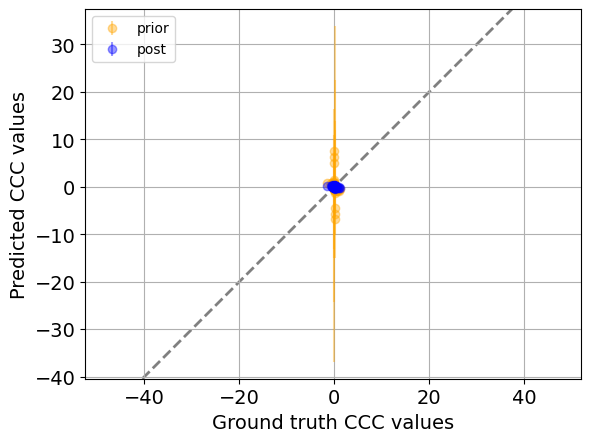

In [36]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC.melt()['value'], priorCCC_meds['median'], yerr=CCC_errors_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC.melt()['value'], postCCC_meds['median'], yerr=CCC_errors_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth CCC values', size=14)
plt.ylabel('Predicted CCC values', size=14)

plt.xticks(size=14)
plt.yticks(size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs.svg', format="svg")

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, -8.0, '−8'),
  Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10')])

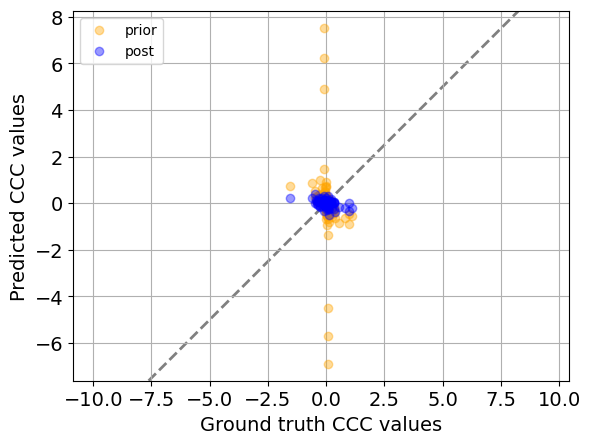

In [37]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtCCC.melt()['value'], priorCCC_meds['median'], alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtCCC.melt()['value'], postCCC_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth CCC values', size=14)
plt.ylabel('Predicted CCC values', size=14)

plt.xticks(size=14)
plt.yticks(size=14)

# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianCCCs.svg', format="svg")

## Calculating FCCs

In [38]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [39]:
priorFCC01 = util_pytensor.estimate_FCCs(BMCA_obj01, Ex01_prior.reshape((19, -1)))
priorFCC02 = util_pytensor.estimate_FCCs(BMCA_obj02, Ex02_prior.reshape((19, -1)))
priorFCC03 = util_pytensor.estimate_FCCs(BMCA_obj03, Ex03_prior.reshape((19, -1)))
priorFCC04 = util_pytensor.estimate_FCCs(BMCA_obj04, Ex04_prior.reshape((19, -1)))
priorFCC05 = util_pytensor.estimate_FCCs(BMCA_obj05, Ex05_prior.reshape((19, -1)))

priorFCC15 = util_pytensor.estimate_FCCs(BMCA_obj15, Ex15_prior.reshape((19, -1)))
priorFCC3 = util_pytensor.estimate_FCCs(BMCA_obj3, Ex3_prior.reshape((19, -1)))
priorFCC5 = util_pytensor.estimate_FCCs(BMCA_obj5, Ex5_prior.reshape((19, -1)))
priorFCC7 = util_pytensor.estimate_FCCs(BMCA_obj7, Ex7_prior.reshape((19, -1)))
priorFCC100 = util_pytensor.estimate_FCCs(BMCA_obj100, Ex100_prior.reshape((19, -1)))


In [40]:
postFCC01 = util_pytensor.estimate_FCCs(BMCA_obj01, Ex01_advi.reshape((19, -1)))
postFCC02 = util_pytensor.estimate_FCCs(BMCA_obj02, Ex02_advi.reshape((19, -1)))
postFCC03 = util_pytensor.estimate_FCCs(BMCA_obj03, Ex03_advi.reshape((19, -1)))
postFCC04 = util_pytensor.estimate_FCCs(BMCA_obj04, Ex04_advi.reshape((19, -1)))
postFCC05 = util_pytensor.estimate_FCCs(BMCA_obj05, Ex05_advi.reshape((19, -1)))

postFCC15 = util_pytensor.estimate_FCCs(BMCA_obj15, Ex15_advi.reshape((19, -1)))
postFCC3 = util_pytensor.estimate_FCCs(BMCA_obj3, Ex3_advi.reshape((19, -1)))
postFCC5 = util_pytensor.estimate_FCCs(BMCA_obj5, Ex5_advi.reshape((19, -1)))
postFCC7 = util_pytensor.estimate_FCCs(BMCA_obj7, Ex7_advi.reshape((19, -1)))
postFCC100 = util_pytensor.estimate_FCCs(BMCA_obj100, Ex100_advi.reshape((19, -1)))

In [41]:
prior_FCCs = [priorFCC01, priorFCC02, priorFCC03, priorFCC04, priorFCC05, priorFCC15, priorFCC3, priorFCC5, priorFCC7, priorFCC100]
post_FCCs = [postFCC01, postFCC02, postFCC03, postFCC04, postFCC05, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]


In [42]:
priorFCC_meds = [-pd.DataFrame(np.median(priorFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for priorFCC in prior_FCCs]
priorFCC_meds = pd.concat([i.melt()['value'] for i in priorFCC_meds], axis=1).values
priorFCC_meds = pd.DataFrame(priorFCC_meds, columns=pt_labels)
priorFCC_meds['median'] = priorFCC_meds.median(axis=1)
priorFCC_meds['min'] = priorFCC_meds.min(axis=1)
priorFCC_meds['max'] = priorFCC_meds.max(axis=1)
# priorFCC_meds

FCC_lower_y_prior = np.array(priorFCC_meds['median']) - np.array(priorFCC_meds['min'])
FCC_upper_y_prior = np.array(priorFCC_meds['max']) - np.array(priorFCC_meds['median'])
FCC_errors_prior = [FCC_lower_y_prior, FCC_upper_y_prior]

In [43]:
postFCC_meds = [-pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()) for postFCC in post_FCCs]
postFCC_meds = pd.concat([i.melt()['value'] for i in postFCC_meds], axis=1).values
postFCC_meds = pd.DataFrame(postFCC_meds, columns=pt_labels)
postFCC_meds['median'] = postFCC_meds.median(axis=1)
postFCC_meds['min'] = postFCC_meds.min(axis=1)
postFCC_meds['max'] = postFCC_meds.max(axis=1)
# postFCC_meds

FCC_lower_y_post = np.array(postFCC_meds['median']) - np.array(postFCC_meds['min'])
FCC_upper_y_post = np.array(postFCC_meds['max']) - np.array(postFCC_meds['median'])
FCC_errors_post = [FCC_lower_y_post, FCC_upper_y_post]

## FCC graphs

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, -40.0, '−40'),
  Text(0, -30.0, '−30'),
  Text(0, -20.0, '−20'),
  Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40')])

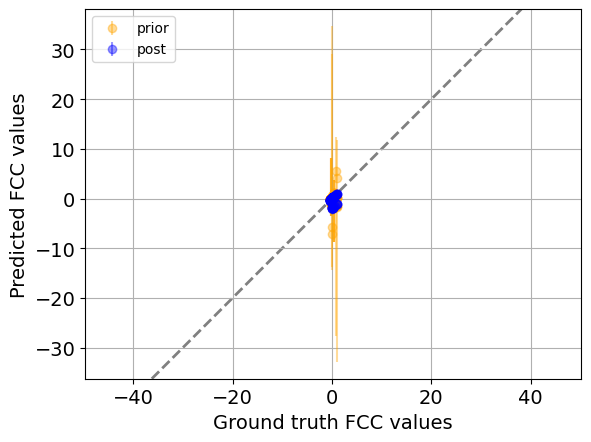

In [44]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_meds['median'], yerr=FCC_errors_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], yerr=FCC_errors_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=14)
plt.ylabel('Predicted FCC values', size=14)

plt.xticks(size=14)
plt.yticks(size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs.svg', format="svg")

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, -8.0, '−8'),
  Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8')])

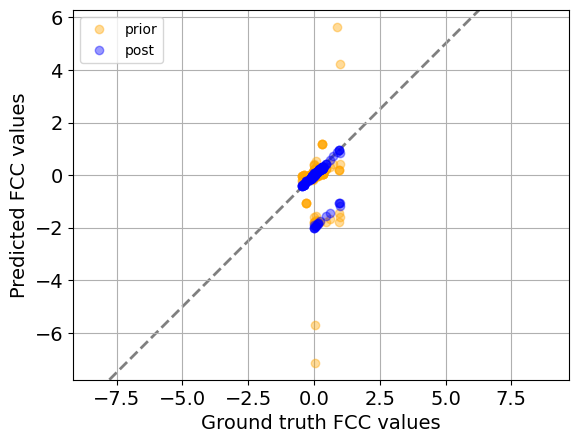

In [45]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_meds['median'], alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=14)
plt.ylabel('Predicted FCC values', size=14)

plt.xticks(size=14)
plt.yticks(size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs.svg', format="svg")

### adding corrections for where the enzyme perturbed is directly involved in the reaction

In [46]:
rxn = np.repeat(r.getReactionIds(),len(r.getReactionIds()))
enz_pt = r.getReactionIds() * len(r.getReactionIds())
FCC_idx = pd.DataFrame([rxn, enz_pt]).T

In [47]:
pt_enz_is_rxn = np.linspace(0,len(rxn)-1,len(r.getReactionIds()))
pt_enz_is_rxn

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180., 200.,
       220., 240., 260., 280., 300., 320., 340., 360.])

### graphing the corrected FCC dfs

In [48]:
priorFCC_meds.loc[pt_enz_is_rxn, 'median'] += 2
postFCC_meds.loc[pt_enz_is_rxn, 'median'] += 2

(array([-40., -30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, -40.0, '−40'),
  Text(0, -30.0, '−30'),
  Text(0, -20.0, '−20'),
  Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40')])

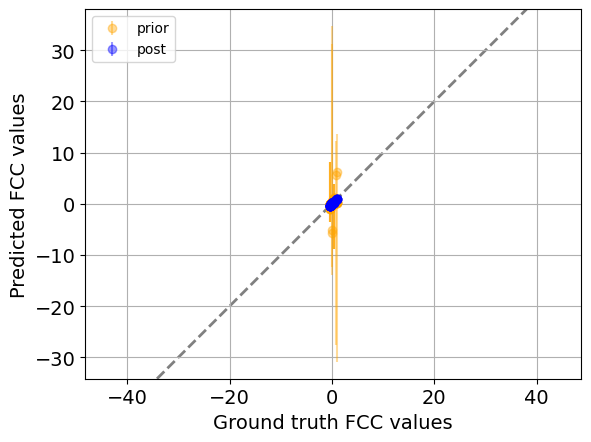

In [49]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_meds['median'], yerr=FCC_errors_prior, alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], yerr=FCC_errors_post, alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=14)
plt.ylabel('Predicted FCC values', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_wCorrection.svg', format="svg")

(array([-8., -6., -4., -2.,  0.,  2.,  4.,  6.,  8.]),
 [Text(0, -8.0, '−8'),
  Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8')])

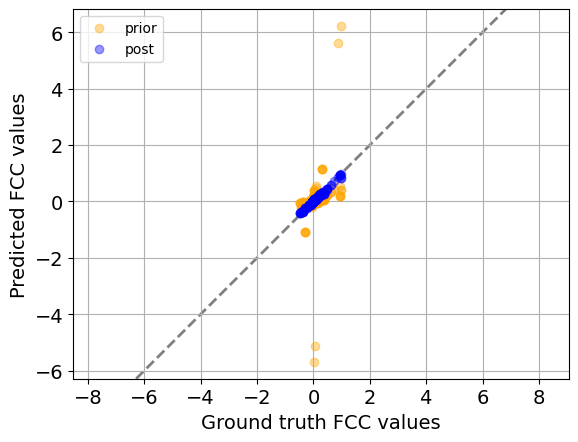

In [50]:
plt.axes().set_aspect('equal', 'datalim')

plt.errorbar(gtFCC.melt()['value'], priorFCC_meds['median'], alpha=0.4, fmt='o', label='prior', zorder=100, c='orange')
plt.errorbar(gtFCC.melt()['value'], postFCC_meds['median'], alpha=0.4, fmt='o', label='post', zorder=100, c='b')

plt.legend(loc="upper left")
plt.axline([0, 0], [1, 1], c='gray', linestyle='dashed', zorder=1, linewidth=2)
plt.grid(True, which='both', axis='both', zorder=0)
plt.xlabel('Ground truth FCC values', size=14)
plt.ylabel('Predicted FCC values', size=14)
plt.xticks(size=14)
plt.yticks(size=14)
# plt.savefig(f'../data/results/raw_svg_figures/top{topology}-{omission}-medianFCCs_wCorrection.svg', format="svg")